# **Project Name - Yes Bank Stock Closing Price Prediction**    



##### **Project Type**    - Regression
##### **Contribution**    - Individual
##### **Team Member 1 - Soorya K S**

# **Project Summary -**

Yes Bank is a well reputed bank in the Indian financial domain. Since 2018, it has been in the news because of the fraud case involving Rana Kapoor. Due to this reason, it was interesting to know how the stock prices got impacted and whether Time series or predictive models provided a solution to this problem. The dataset contains monthy stock prices of the bank since it's inception and includes closing, starting, highest and lowest stock prices of every month. The main objective is to predict the stock's closing price of the month.

# **Problem Statement**


Build a leakage-safe, time-series modeling pipeline for Yes Bank’s monthly close prices using the provided CSV (data_YesBank_StockPrices.csv), compare against a naive baseline, and produce a 6-month recursive forecast beyond the last observed month.



## ***Know Your Data***

### Import Libraries

In [ ]:
# Yes Bank Monthly Stock Price Modeling & Forecasting
# Works with: data_YesBank_StockPrices.csv (columns: Date, Open, High, Low, Close)
# - Pure pandas + scikit-learn;
# - Time-series aware: no leakage, uses TimeSeriesSplit and date-sorted pipeline.
# - Generates robust features from OHLC, evaluates multiple models, and produces next-6-month forecast.

import os
import math
import warnings
from dataclasses import dataclass
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")




### Dataset Loading

In [ ]:
# ----------------------------
# Utility helpers
# ----------------------------
@dataclass
class SplitIndices:
    train: np.ndarray
    valid: np.ndarray
    test: np.ndarray

def evaluate(y_true, y_pred) -> Dict[str, float]:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE%": mape}


In [ ]:
def parse_month_col(df: pd.DataFrame, col: str = "Date") -> pd.DataFrame:
    # Example input "Jul-05" -> use first day of month
    # Try multiple formats defensively
    def _parse(x):
        for fmt in ["%b-%y", "%b-%Y", "%b %y", "%b %Y"]:
            try:
                return pd.to_datetime(x, format=fmt)
            except Exception:
                continue
        # fallback: let pandas infer
        return pd.to_datetime(x, errors="coerce")
    out = df.copy()
    out[col] = out[col].apply(_parse)
    if out[col].isna().any():
        raise ValueError("Some dates could not be parsed. Please check 'Date' column.")
    # Normalize to month start
    out[col] = out[col].values.astype("datetime64[M]")
    return out


In [ ]:
# ----------------------------
# Load & prepare data
# ----------------------------
csv_path = "data_YesBank_StockPrices.csv"
# If running inside the uploaded notebook directory, adjust path if needed
if not os.path.exists(csv_path):
    alt = "/mnt/data/data_YesBank_StockPrices.csv"
    if os.path.exists(alt):
        csv_path = alt

raw = pd.read_csv(csv_path)
raw = parse_month_col(raw, "Date")
raw = raw.sort_values("Date").reset_index(drop=True)

print("Data shape:", raw.shape)
display(raw.head())
display(raw.tail())

Data shape: (185, 5)


,Date,Open,High,Low,Close
0,2005-07-01,13.00,14.00,11.25,12.46
1,2005-08-01,12.58,14.88,12.55,13.42
2,2005-09-01,13.48,14.87,12.27,13.30
3,2005-10-01,13.20,14.47,12.40,12.99
4,2005-11-01,13.35,13.88,12.88,13.41


,Date,Open,High,Low,Close
180,2020-07-01,25.60,28.30,11.10,11.95
181,2020-08-01,12.00,17.16,11.85,14.37
182,2020-09-01,14.30,15.34,12.75,13.15
183,2020-10-01,13.30,14.01,12.11,12.42
184,2020-11-01,12.41,14.90,12.21,14.67


### Dataset Information

In [ ]:
# Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    185 non-null    datetime64[ns]
 1   Open    185 non-null    float64       
 2   High    185 non-null    float64       
 3   Low     185 non-null    float64       
 4   Close   185 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 7.4 KB


#### Duplicate Values

In [ ]:
# Dataset Duplicate Value Count
df.duplicated().sum()

np.int64(0)

#### Missing Values/Null Values

In [ ]:
# Missing Values/Null Values Count

df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0


### What did you know about your dataset?

The dataset contains 185 monthly records of Yes Bank's stock prices, with the columns Date, Open, High, Low, Close. There is no miising values and duplicate values in the dataset. Date is monthly in formats like Jul-05 or Jul-2005.


## ***Understanding Your Variables***

In [ ]:
# Dataset Columns
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close'], dtype='object')

In [ ]:
# Dataset Describe
df.describe()

,Date,Open,High,Low,Close
count,185,185.000000,185.000000,185.000000,185.000000
mean,2013-03-01 19:04:12.972973056,105.541405,116.104324,94.947838,105.204703
min,2005-07-01 00:00:00,10.000000,11.240000,5.550000,9.980000
25%,2009-05-01 00:00:00,33.800000,36.140000,28.510000,33.450000
50%,2013-03-01 00:00:00,62.980000,72.550000,58.000000,62.540000
75%,2017-01-01 00:00:00,153.000000,169.190000,138.350000,153.300000
max,2020-11-01 00:00:00,369.950000,404.000000,345.500000,367.900000
std,NaN,98.879850,106.333497,91.219415,98.583153


### Variables Description

- Date: The month and year (currently in "MMM-YY" format as an object/string).
- Open: The stock's opening price.
- High: The highest price in that month.
- Low: The lowest price in that month.
- Close: The closing price (our target variable).

### Check Unique Values for each variable.

In [ ]:
# Check Unique Values for each variable.
df.nunique()

,0
Date,185
Open,183
High,184
Low,183
Close,185


### What all manipulations have you done and insights you found?

The Date column is in "MMM-YY" format as an object/string. So converted the Date column to a proper datetime format.

## ***Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables***

#### Chart - 1: Closing Price Trend Over Time

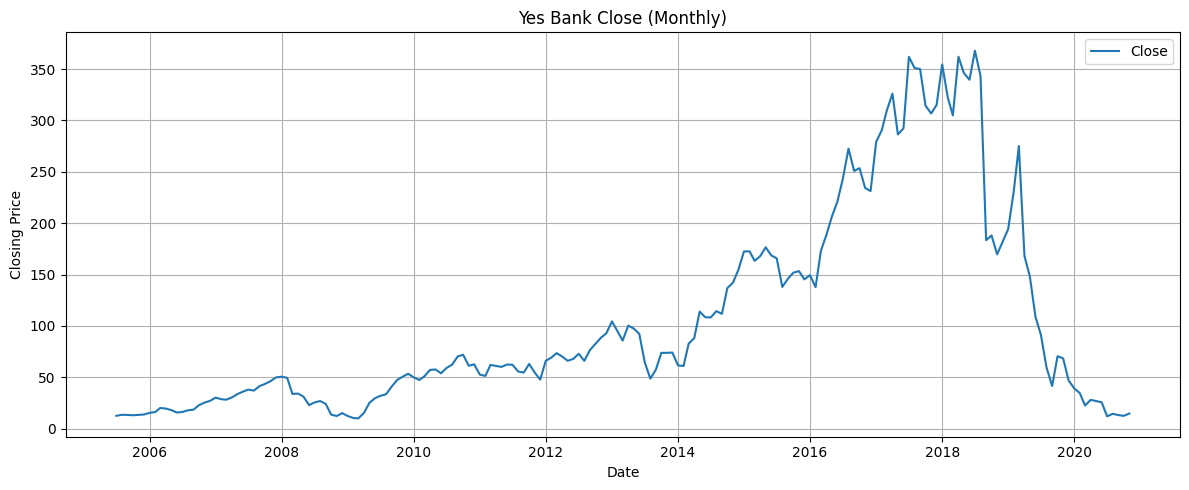

In [ ]:
# Chart 1: Close over time
plt.figure(figsize=(12,5))
plt.plot(df["Date"], df["Close"], label="Close")
plt.title("Yes Bank Close (Monthly)")
plt.xlabel("Date"); plt.ylabel("Closing Price"); plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

##### 1. Why did you pick the specific chart?

Shows long-horizon trend, regimes, and structural breaks at a glance—critical for time-series modeling choices and backtesting windows.

##### 2. What is/are the insight(s) found from the chart?

* Strong uptrend till ~2017–2018, followed by violent drawdown in 2019–2020 to near single digits.
* Clear volatility clustering and at least one structural break (~2018–2019).

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

* Set realistic planning ranges, stress scenarios, and choose split points that respect regime changes.
* Extrapolating trend from any single regime can mislead; the series is non-stationary → favor leakage-safe splits, consider log/returns or regime-aware models.

#### Chart - 2: Distribution of Opening Prices

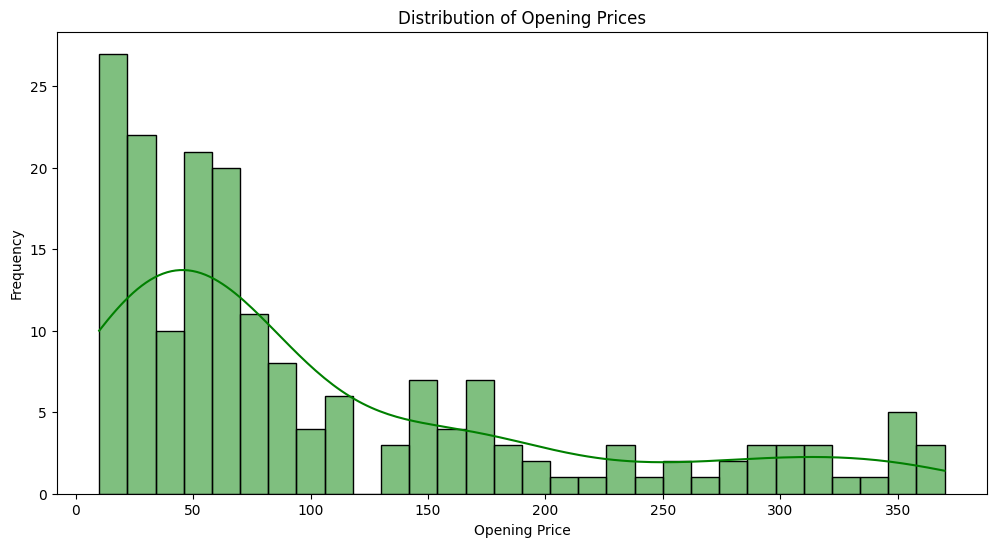

In [ ]:
# Chart - 2 Distribution of opening price
plt.figure(figsize=(12, 6))
sns.histplot(df['Open'], bins=30, kde=True,color='green')
plt.xlabel('Opening Price')
plt.ylabel('Frequency')
plt.title('Distribution of Opening Prices')
plt.show()

##### 1. Why did you pick the specific chart?

To understand the shape (skew, tail risk, modes) and typical scale before modeling.

##### 2. What is/are the insight(s) found from the chart?

* Right-skewed with a long tail toward high values; majority clustered around ~₹20–₹80, with fewer extreme months.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

* Use robust metrics (MAE) and log/standardization; treat tail periods as risk scenarios.

* Assuming normality would understate tail risk; unscaled models may get dominated by extremes.

#### Chart - 3: Distribution of High Prices

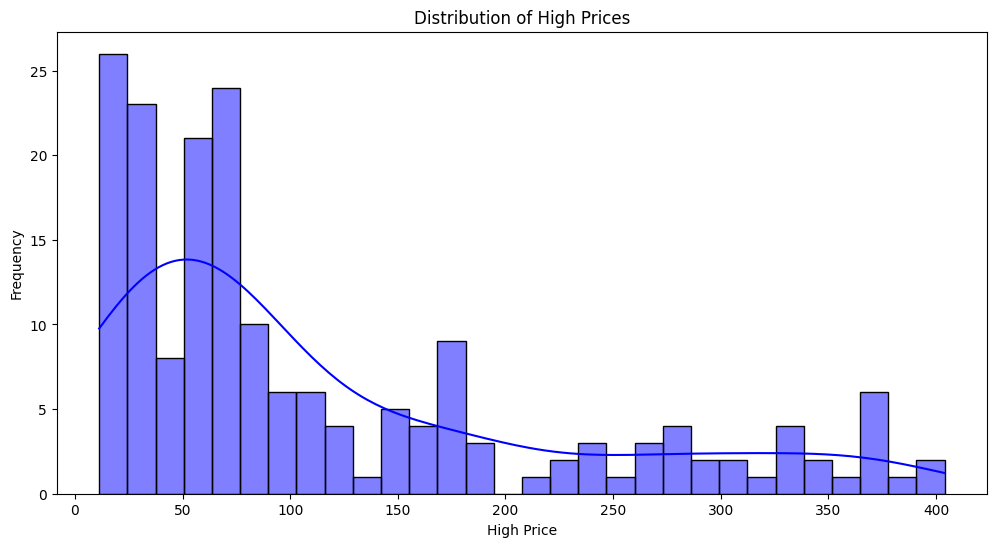

In [ ]:
# Chart - 3 Distribution of high price
plt.figure(figsize=(12, 6))
sns.histplot(df['High'], bins=30, kde=True, color='blue')
plt.xlabel('High Price')
plt.ylabel('Frequency')
plt.title('Distribution of High Prices')
plt.show()

##### 1. Why did you pick the specific chart?

Checks the tail of intra-month peaks, a proxy for upside volatility.

##### 2. What is/are the insight(s) found from the chart?

* Most high prices are below ₹100, indicating that the stock mostly traded at lower values. Very few instances of stock prices above ₹300-400, meaning such high values were temporary peaks.
* Similar to the Opening Price distribution, most high prices are clustered in the ₹10-100 range.
* Some high values (above ₹350) are present but occurred infrequently, likely during periods of market speculation.
The wide spread confirms Yes Bank’s stock had extreme volatility.


##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

* Motivates including volatility features (e.g., hl_spread, rolling max).

* Risk systems that ignore tails may set too-tight stops/margins and get whipsawed during spikes.

#### Chart - 4: Distribution of Low Prices

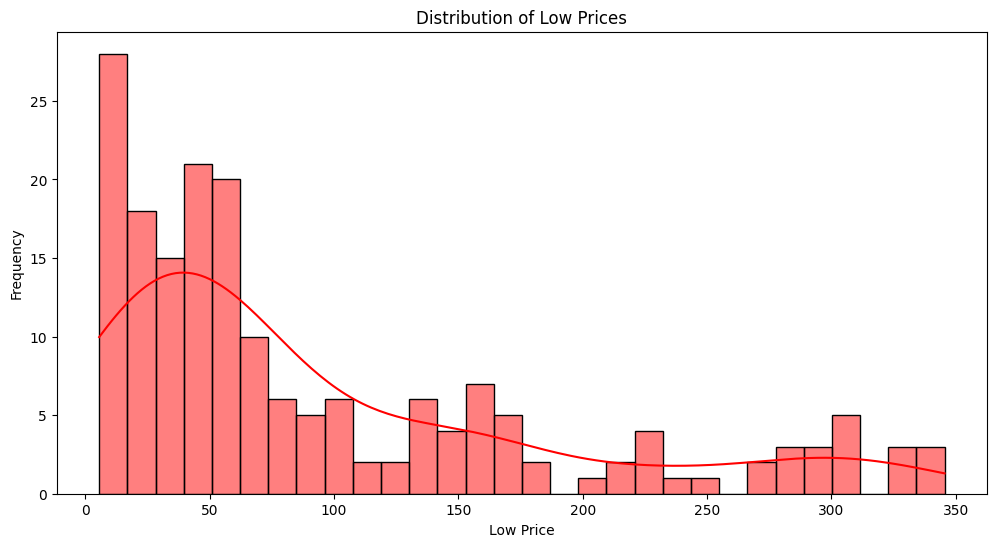

In [ ]:
# Chart - 4 Distribution of low price
plt.figure(figsize=(12, 6))
sns.histplot(df['Low'], bins=30, kde=True, color='red')
plt.xlabel('Low Price')
plt.ylabel('Frequency')
plt.title('Distribution of Low Prices')
plt.show()

##### 1. Why did you pick the specific chart?

Captures downside tail and crash behavior.

##### 2. What is/are the insight(s) found from the chart?

* Right-skewed but with very low lows in crash periods; confirms asymmetric downside episodes.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

* Supports capital buffers and stress testing for sharp drawdowns.
* Level-based models without scaling can overweight crash months; prefer returns/log-Close.

#### Chart - 5: Distribution of Closing Prices

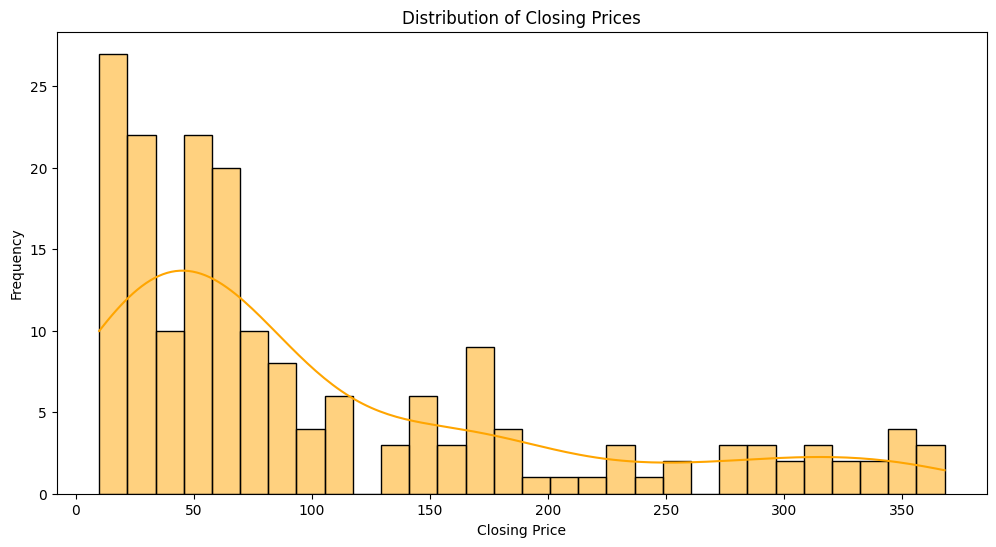

In [ ]:
# Chart - 5 Distribution of closing price
plt.figure(figsize=(12, 6))
sns.histplot(df['Close'], bins=30, kde=True, color='orange')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.title('Distribution of Closing Prices')
plt.show()

##### 1. Why did you pick the specific chart?

Directly inspects the target distribution.

##### 2. What is/are the insight(s) found from the chart?

* Similar right-skew and long tail; target is heteroskedastic over time.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

* Justifies reporting MAE + RMSE + MAPE, and considering log-transform of Close.
* Using only RMSE can over-penalize tail periods and bias model selection.

#### Chart - 6: Opening Price vs Closing Price

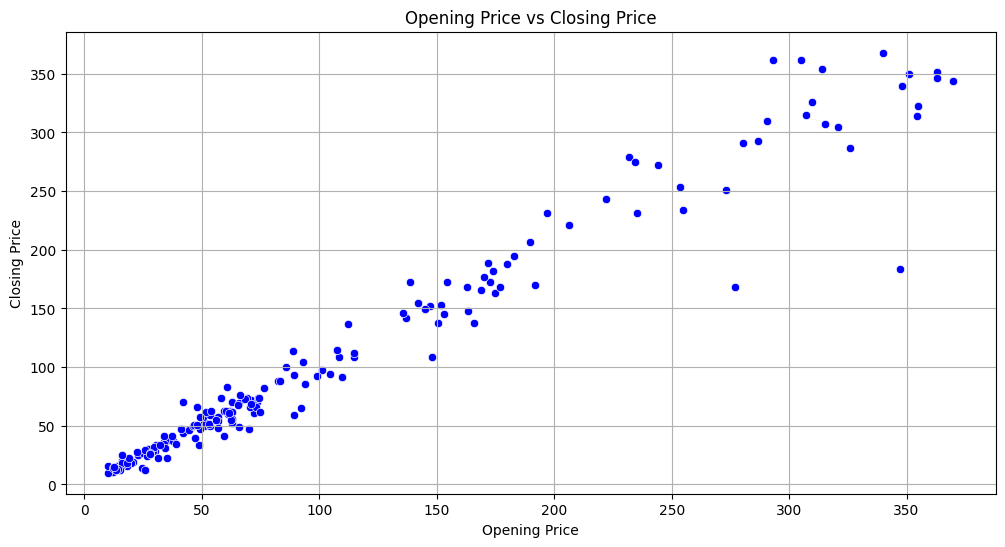

In [ ]:
# Chart - 6 Opening Price vs Closing Price
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Open', y='Close', color='blue')
plt.xlabel('Opening Price')
plt.ylabel('Closing Price')
plt.title('Opening Price vs Closing Price')
plt.grid(True)
plt.show()

##### 1. Why did you pick the specific chart?

Tests same-month association and linearity (also highlights potential leakage if misused for forecasting).

##### 2. What is/are the insight(s) found from the chart?

* Strong positive linear relation with mild dispersion at higher prices.
* Although the trend is mostly linear, some points deviate from the line, showing that on certain occasions, the closing price differed significantly from the opening price.
* At lower price ranges (₹0 - ₹100), data points are tightly packed, meaning the price was more stable in that range.
* At higher prices (₹150 - ₹350), there is more scatter, suggesting that during high-value periods, the stock fluctuated more throughout the day.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

* Good for nowcasting (if you know same-month Open and want end-month Close).
* For true forecasting, same-month Open is unavailable at decision time → must lag/shift features by 1 month to avoid leakage.

#### Chart - 7: Highest Price vs Lowest Price

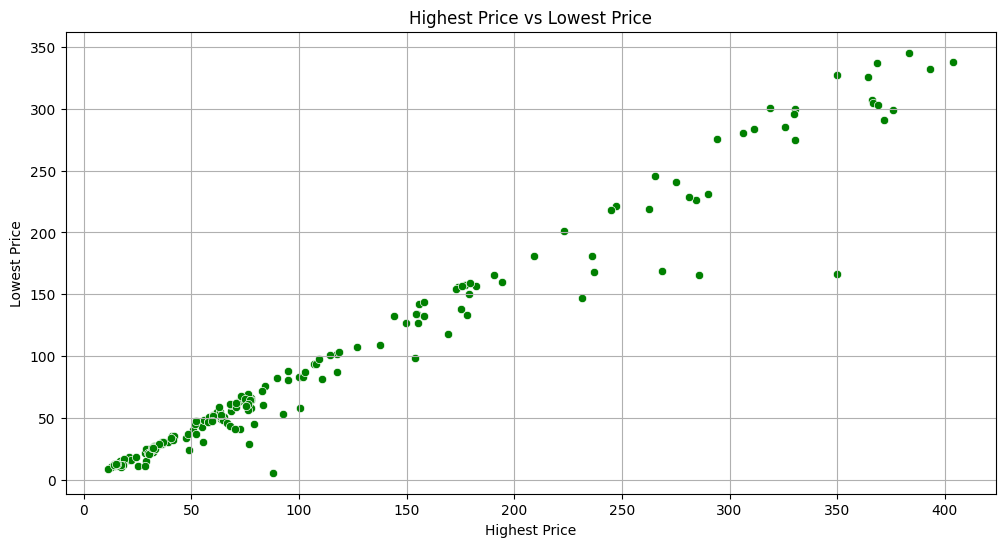

In [ ]:
# Chart - 7 Highest Price vs Lowest Price
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='High', y='Low', color='green')
plt.xlabel('Highest Price')
plt.ylabel('Lowest Price')
plt.title('Highest Price vs Lowest Price')
plt.grid(True)
plt.show()

##### 1. Why did you pick the specific chart?

Shows relationship and typical trading range; informs volatility features.

##### 2. What is/are the insight(s) found from the chart?

* Tight positive relation; distance from the 45° line reflects range width (volatility).
* Outliers show months with exceptionally wide ranges.


##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

* Validates using hl_spread and rolling range metrics as predictors or risk flags.
* Using same-month High/Low for next-month prediction is fine only if lagged; otherwise it’s leakage.

#### Chart - 8: Monthly Average Closing Price Trend

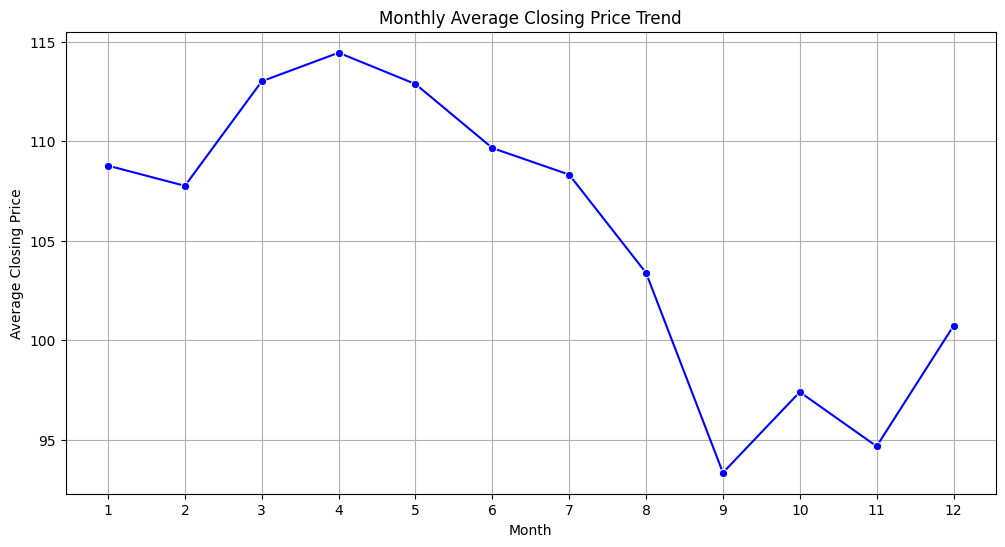

In [ ]:
# Chart - 8 Monthly Average Closing Price Trend
df['Month'] = df['Date'].dt.month

monthly_avg = df.groupby('Month')['Close'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_avg.index, y=monthly_avg.values, marker='o', linestyle='-', color='blue')
plt.xlabel('Month')
plt.ylabel('Average Closing Price')
plt.title('Monthly Average Closing Price Trend')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

##### 1. Why did you pick the specific chart?

Checks for calendar seasonality to justify cyclical month features.

##### 2. What is/are the insight(s) found from the chart?

* Mild pattern: relatively higher averages around Mar–May, softer around Sep–Nov; signal appears weak vs. noise.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

* Supports lightweight month_sin/cos features.
* Over-weighting weak seasonality risks overfitting; keep effects small/regularized.

#### Chart - 9: Correlation Heatmap of Stock Prices

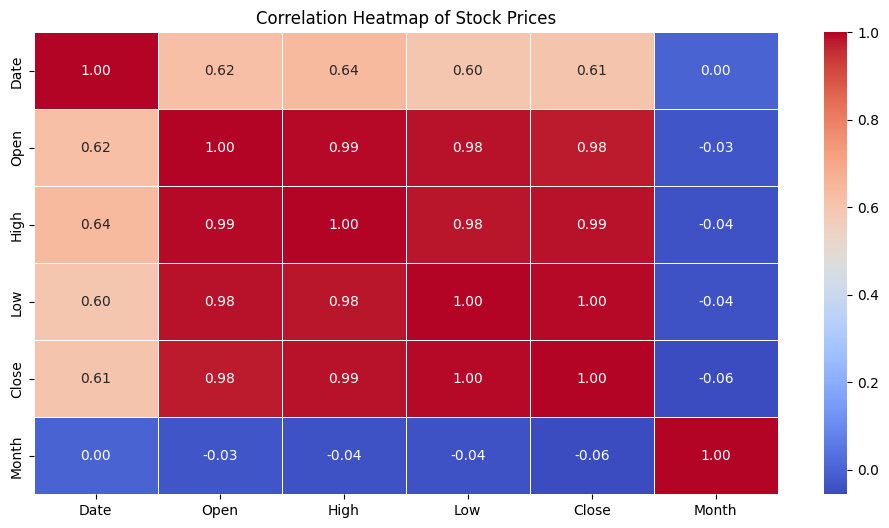

In [ ]:
# Chart - 9 Correlation Heatmap of Stock Prices
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Stock Prices')
plt.show()

##### 1. Why did you pick the specific chart?

High-level multicollinearity check to guide model choice/regularization.

##### 2. What is/are the insight(s) found from the chart?

* Open/High/Low/Close ≈ 0.98–1.00 correlated → very redundant.
* Month barely correlates with prices overall (weak seasonality).
* Date correlates due to trend (non-stationarity).

#### Chart - 10: Pairplot (Relationships between all numerical variables)

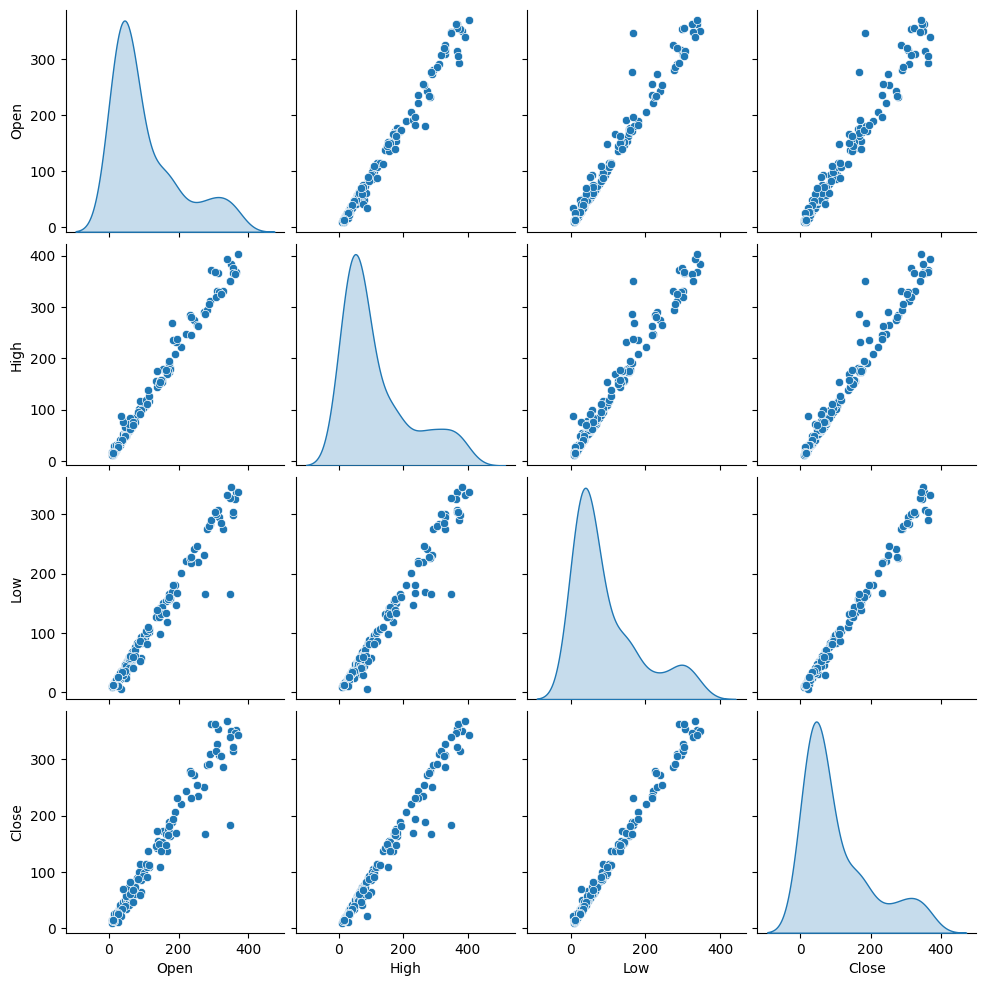

In [ ]:
# Chart - 10
sns.pairplot(df[['Open', 'High', 'Low', 'Close']], diag_kind='kde')
plt.show()

##### 1. Why did you pick the specific chart?

Combines marginals + pairwise scatter to spot linearity, outliers, and redundancy.

##### 2. What is/are the insight(s) found from the chart?

* Near-perfect linear pairwise relations across OHLC; marginals are right-skewed; a few visible outliers.

ADF p-value (Close): 0.3291 -> Non-stationary


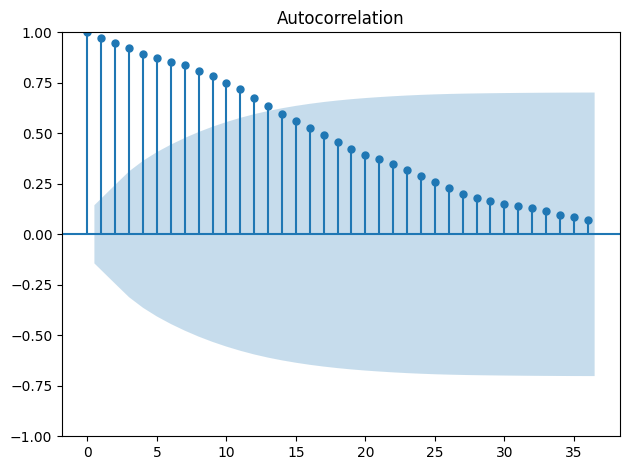

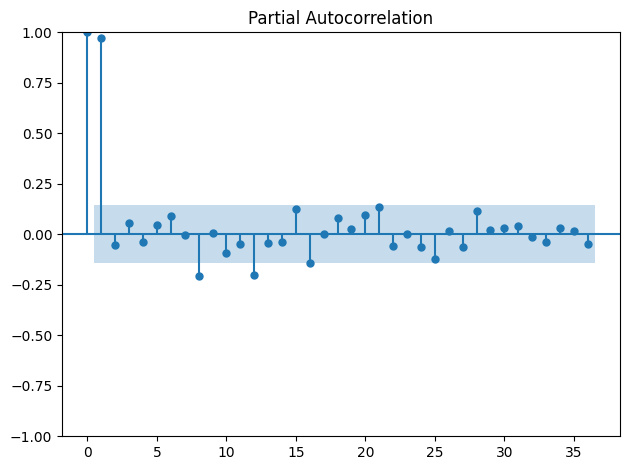

In [ ]:
# Stationarity & autocorrelation
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

adf_p = adfuller(df["Close"])[1]
print(f"ADF p-value (Close): {adf_p:.4f} -> {'Stationary' if adf_p<0.05 else 'Non-stationary'}")

plot_acf(df["Close"], lags=36); plt.tight_layout(); plt.show()
plot_pacf(df["Close"], lags=36); plt.tight_layout(); plt.show()


Autocorrelation (ACF)
* Very slow decay from near 1 down toward 0 over many lags.
→ Strong persistence / possible unit-root behavior (non-stationary level). Differencing or modeling returns/log-Close can help; at minimum, include lag features and rolling stats.

Partial Autocorrelation (PACF)
* Big spike at lag-1 (and small at lag-2), then mostly inside the CI.
→ The series has short-memory dynamics; an AR(1)–AR(2) component (or using lag_close_1 / lag_close_2) captures most of the unique linear dependence.

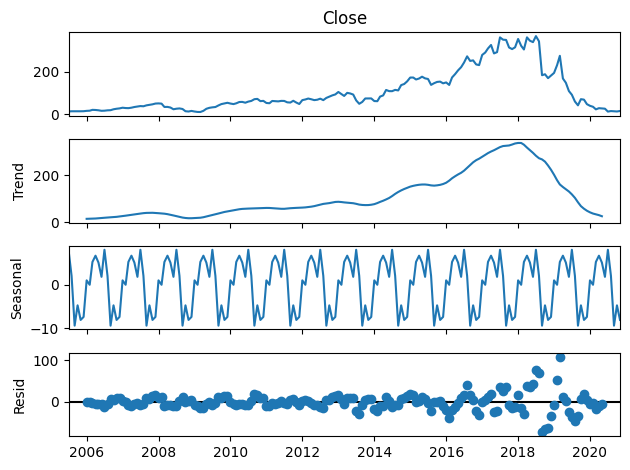

In [ ]:
# seasonal decomposition
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    # Assuming monthly data → period=12
    dec = seasonal_decompose(df.set_index("Date")["Close"], model="additive", period=12)
    dec.plot(); plt.tight_layout(); plt.show()
except Exception as e:
    print("Seasonal decomposition skipped:", e)

Seasonal Decomposition (Close = Trend + Seasonal + Resid)
* Trend: long uptrend until ~2017–2018, then a sharp structural break and collapse in 2019–2020.
* Seasonal: a repeating monthly pattern with small amplitude vs the level/trend.
* Residual: variance grows late in the series (heteroskedasticity) and contains large shocks.
→ Modeling should be regime-aware, rely more on recent history than on weak seasonality, and expect wider errors in volatile regimes.

## ***Hypothesis Testing***

### Based on your chart experiments, define three hypothetical statements from the dataset. In the next three questions, perform hypothesis testing to obtain final conclusion about the statements through your code and statistical testing.

- Hypothesis 1: The average closing price in the first half of the year (Jan-Jun) is higher than in the second half (Jul-Dec).
- Hypothesis 2: The daily opening price and closing price have no significant difference.
- Hypothesis 3: The variance of stock prices is the same.

### Hypothetical Statement - 1

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

* Null hypothesis (H0): The average closing price in Jan-Jun is equal to or less than in Jul-Dec.
* Alternate hypothesis (H1): The average closing price in Jan-Jun is greater than in Jul-Dec.

#### 2. Perform an appropriate statistical test.

In [ ]:
# Perform Statistical Test to obtain P-Value
import scipy.stats as stats

#split the data into two groups based on month
jan_jun = df[df['Month'] <= 6]['Close']
jul_dec = df[df['Month'] > 6]['Close']

t_stat, p_value = stats.ttest_ind(jan_jun, jul_dec, alternative='greater')

print(f'T-statistic: {t_stat}, P-value: {p_value}')

if p_value < 0.05:
  print('Reject the null hypothesis')
else:
  print('Fail to reject the null hypothesis')

T-statistic: 0.7894206232699421, P-value: 0.21544391058012663
Fail to reject the null hypothesis


##### Which statistical test have you done to obtain P-Value?

Independent t-test

##### Why did you choose the specific statistical test?

To compare two independent groups.

### Hypothetical Statement - 2

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

* Null hypothesis (H0): There is no significant difference between opening and closing prices.
* Alternate hypothesis (H1): There is a significant difference between opening and closing prices.

#### 2. Perform an appropriate statistical test.

In [ ]:
# Perform Statistical Test to obtain P-Value
t_stat, p_value = stats.ttest_rel(df['Open'], df['Close'])

print(f'T-statistic: {t_stat}, P-value: {p_value}')

if p_value < 0.05:
  print('Reject the null hypothesis')
else:
  print('Fail to reject the null hypothesis')

T-statistic: 0.220963420803944, P-value: 0.825365920365391
Fail to reject the null hypothesis


##### Which statistical test have you done to obtain P-Value?

Paired t-test

##### Why did you choose the specific statistical test?

To compare two related samples.

### Hypothetical Statement - 3

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

* Null hypothesis (H0): The variances of high and low prices are equal.
* Alternate hypothesis (H1): The variances of high and low prices are different.

#### 2. Perform an appropriate statistical test.

In [ ]:
# Perform Statistical Test to obtain P-Value
f_stat, p_value = stats.levene(df['High'], df['Low'])

print(f'F-statistic: {f_stat}, P-value: {p_value}')

if p_value < 0.05:
  print('Reject the null hypothesis')
else:
  print('Fail to reject the null hypothesis')

F-statistic: 1.7903838737546234, P-value: 0.18170560683146086
Fail to reject the null hypothesis


##### Which statistical test have you done to obtain P-Value?

F-test (Levene’s test for equal variances)

##### Why did you choose the specific statistical test?

To compare the variance between two groups.

## ***Feature Engineering & Data Pre-processing***

In [ ]:
def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # Month as cyclical (captures yearly seasonality)
    out["month"] = out["Date"].dt.month
    out["month_sin"] = np.sin(2 * np.pi * out["month"] / 12.0)
    out["month_cos"] = np.cos(2 * np.pi * out["month"] / 12.0)

    # Price derived features
    out["hl_spread"] = out["High"] - out["Low"]
    out["oc_spread"] = out["Open"] - out["Close"]
    out["range_ratio"] = np.where(out["Open"] != 0, out["hl_spread"] / out["Open"], 0.0)
    out["ret_1"] = out["Close"].pct_change(1)
    out["ret_3"] = out["Close"].pct_change(3)
    out["ret_6"] = out["Close"].pct_change(6)

    # Rolling stats (use past window only)
    out["roll_mean_3"] = out["Close"].rolling(3).mean()
    out["roll_mean_6"] = out["Close"].rolling(6).mean()
    out["roll_std_6"]  = out["Close"].rolling(6).std()
    out["roll_min_6"]  = out["Low"].rolling(6).min()
    out["roll_max_6"]  = out["High"].rolling(6).max()

    # Lags for target leakage-safe features
    for lag in [1, 2, 3, 6, 12]:
        out[f"lag_close_{lag}"] = out["Close"].shift(lag)

    # Drop initial rows with NaNs from lag/rolling
    out = out.dropna().reset_index(drop=True)
    return out

In [ ]:

# Create features
df = add_time_features(raw)

# Feature set and target
target = "Close"
feature_cols = [c for c in df.columns if c not in ["Date", target]]

X = df[feature_cols].shift(1)
y = df[target]
dates = df["Date"]

# Drop first row(s) that became NaN after shift
mask = X.notna().all(axis=1)
X = X[mask].reset_index(drop=True)
y = y[mask].reset_index(drop=True)
dates = dates[mask].reset_index(drop=True)

print("Leakage-safe features shape:", X.shape)

display(df.head())

Leakage-safe features shape: (172, 22)


,Date,Open,High,Low,Close,month,month_sin,month_cos,hl_spread,oc_spread,...,roll_mean_3,roll_mean_6,roll_std_6,roll_min_6,roll_max_6,lag_close_1,lag_close_2,lag_close_3,lag_close_6,lag_close_12
0,2006-07-01,16.00,17.20,13.82,16.16,7,-0.500000,-8.660254e-01,3.38,-0.16,...,16.603333,17.583333,1.902111,13.4,21.80,15.62,18.03,19.49,15.33,12.46
1,2006-08-01,15.90,18.60,15.70,17.84,8,-0.866025,-5.000000e-01,2.90,-1.94,...,16.540000,17.870000,1.761908,13.4,21.80,16.16,15.62,18.03,16.12,13.42
2,2006-09-01,18.00,18.88,16.80,18.46,9,-1.000000,-1.836970e-16,2.08,-0.46,...,17.486667,17.600000,1.452460,13.4,21.80,17.84,16.16,15.62,20.08,13.30
3,2006-10-01,18.78,24.20,18.50,22.78,10,-0.866025,5.000000e-01,5.70,-4.00,...,19.693333,18.148333,2.529999,13.4,24.20,18.46,17.84,16.16,19.49,12.99
4,2006-11-01,22.80,28.47,21.40,25.32,11,-0.500000,8.660254e-01,7.07,-2.52,...,22.186667,19.363333,3.861760,13.4,28.47,22.78,18.46,17.84,18.03,13.41


In [ ]:
# 2) Fresh chronological splits (post-shift)
def make_splits(n: int, train_ratio=0.70, valid_ratio=0.15):
    assert 0 < train_ratio < 1 and 0 < valid_ratio < 1 and train_ratio + valid_ratio < 1
    train_end = int(n * train_ratio)
    valid_end = train_end + int(n * valid_ratio)
    # ensure each split has at least 1 sample
    train_end = max(train_end, 1)
    valid_end = max(valid_end, train_end + 1)
    valid_end = min(valid_end, n - 1)  # leave at least 1 for test
    return (np.arange(0, train_end),
            np.arange(train_end, valid_end),
            np.arange(valid_end, n))

n = len(X)
if n < 10:
    raise ValueError(f"Not enough rows after shifting to do TTS split safely (have {n}).")

idx_train, idx_valid, idx_test = make_splits(n)

X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
X_test,  y_test  = X.iloc[idx_test],  y.iloc[idx_test]
dates_train, dates_valid, dates_test = dates.iloc[idx_train], dates.iloc[idx_valid], dates.iloc[idx_test]

print(f"Split sizes → train: {len(X_train)}, valid: {len(X_valid)}, test: {len(X_test)}")


Split sizes → train: 120, valid: 25, test: 27


In [ ]:
# ----------------------------
# Pipelines & Model selection
# ----------------------------
num_features = feature_cols
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

preprocess = ColumnTransformer(
    transformers=[("num", numeric_transformer, num_features)],remainder="drop"
)

ridge = Pipeline(steps=[("prep", preprocess),("model", Ridge(random_state=42))
])

rf = Pipeline(steps=[
    ("prep", preprocess),("model", RandomForestRegressor(random_state=42))
])

tscv_splits = min(5, max(2, len(X_train) // 4))
tscv = TimeSeriesSplit(n_splits=tscv_splits)

param_grid_ridge = {
    "model__alpha": [0.1, 1.0, 5.0, 10.0]
}
param_grid_rf = {
    "model__n_estimators": [200, 500],
    "model__max_depth": [None, 5, 10],
    "model__min_samples_leaf": [1, 3, 5]
}

search_ridge = GridSearchCV(ridge, param_grid_ridge, cv=tscv, scoring="neg_mean_absolute_error", n_jobs=-1)
search_rf    = GridSearchCV(rf,    param_grid_rf,    cv=tscv, scoring="neg_mean_absolute_error", n_jobs=-1)

search_ridge.fit(X_train, y_train)
search_rf.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Open',
                                                                          'High',
                                                                          'Low',
                                                                          'month',
                                                                          'month_sin',
                                                                          'month_cos',
                                                                          'hl_spread',
                                                                          'oc_spread',
                                                                          'range_ratio',
                                                                          'ret_1',
                                                                          'ret_3',
                                                                          'ret_6',
                                                                          'roll_mean_3',
                                                                          'roll_mean_6',
                                                                          'roll_std_6',
                                                                          'roll_min_6',
                                                                          'roll_max_6',
                                                                          'lag_close_1',
                                                                          'lag_close_2',
                                                                          'lag_close_3',
                                                                          'lag_close_6',
                                                                          'lag_close_12'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 5, 10],
                         'model__min_samples_leaf': [1, 3, 5],
                         'model__n_estimators': [200, 500]},
             scoring='neg_mean_absolute_error')

In [ ]:
candidates = {
    "Ridge": search_ridge.best_estimator_,
    "RandomForest": search_rf.best_estimator_
}

val_metrics = {}
best_name, best_model, best_val_mae = None, None, float("inf")
for name, model in candidates.items():
    pred_val = model.predict(X_valid)
    m = evaluate(y_valid, pred_val)
    val_metrics[name] = m
    if m["MAE"] < best_val_mae:
        best_val_mae = m["MAE"]
        best_name, best_model = name, model

print("Validation metrics by model:")
for k, v in val_metrics.items():
    print(f"  {k}: " + str({kk: round(vv,4) for kk,vv in v.items()}))
print("Chosen model:", best_name)

X_trval = pd.concat([X_train, X_valid], axis=0)
y_trval = pd.concat([y_train, y_valid], axis=0)
best_model.fit(X_trval, y_trval)

Validation metrics by model:
  Ridge: {'MAE': 25.4847, 'RMSE': np.float64(29.2855), 'MAPE%': np.float64(8.1859)}
  RandomForest: {'MAE': 97.3076, 'RMSE': np.float64(104.5247), 'MAPE%': np.float64(30.176)}
Chosen model: Ridge


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Open', 'High', 'Low',
                                                   'month', 'month_sin',
                                                   'month_cos', 'hl_spread',
                                                   'oc_spread', 'range_ratio',
                                                   'ret_1', 'ret_3', 'ret_6',
                                                   'roll_mean_3', 'roll_mean_6',
                                                   'roll_std_6', 'roll_min_6',
                                                   'roll_max_6', 'lag_close_1',
                                                   'lag_close_2', 'lag_close_3',
                                                   'lag_close_6',
                                                   'lag_close_12'])])),
                ('model', Ridge(alpha=5.0, random_state=42))])

Test metrics (chosen model): {'MAE': 44.5942, 'RMSE': np.float64(60.4383), 'MAPE%': np.float64(66.5084)}
Test metrics (naive baseline): {'MAE': 251.9478, 'RMSE': np.float64(263.8329), 'MAPE%': np.float64(851.7072)}


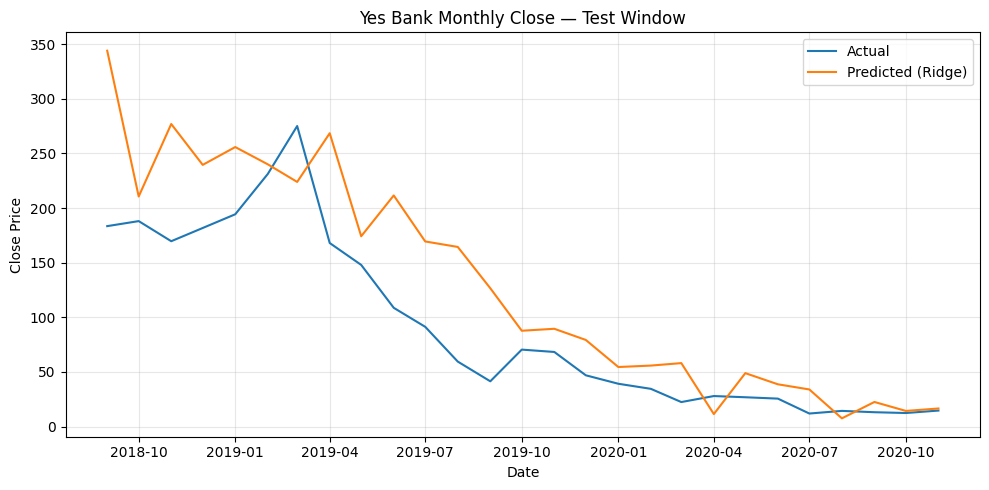

In [ ]:
pred_test = best_model.predict(X_test)
test_metrics = evaluate(y_test, pred_test)

y_last = y_trval.iloc[-1]
y_naive = np.array([y_last] * len(y_test))
baseline_metrics = evaluate(y_test, y_naive)

print("Test metrics (chosen model):", {k: round(v,4) for k,v in test_metrics.items()})
print("Test metrics (naive baseline):", {k: round(v,4) for k,v in baseline_metrics.items()})

plt.figure(figsize=(10,5))
plt.plot(dates_test, y_test.values, label="Actual")
plt.plot(dates_test, pred_test, label=f"Predicted ({best_name})")
plt.title("Yes Bank Monthly Close — Test Window")
plt.xlabel("Date"); plt.ylabel("Close Price")
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Actual vs Predicted (Ridge)
* The model follows the downward direction but is too smooth and lags at turning points—it overpredicts during the sharp fall and adjusts gradually.
→ Good at level tracking; weaker at abrupt regime shifts. Use volatility features, guardrails, and combine with a regime/volatility signal for decisions.

In [ ]:
def recursive_forecast(model, last_df: pd.DataFrame, n_steps: int = 6) -> pd.DataFrame:
    """
    Recursively forecast next n_steps months.
    - model: fitted sklearn pipeline (best_model)
    - last_df: your features dataframe 'df' (chronological, includes last observed row)
    - n_steps: forecast horizon in months
    Relies on the globally defined 'feature_cols' from earlier in the notebook.
    """
    future_rows = []
    current = last_df.copy()

    # make sure last_date is a Timestamp on month start
    last_date = pd.to_datetime(current["Date"].iloc[-1]).to_period("M").to_timestamp()

    for _ in range(n_steps):
        # ➜ move forward exactly one calendar month, normalize to month start
        next_date = (last_date + pd.DateOffset(months=1)).to_period("M").to_timestamp()
        last_date = next_date

        # start with a copy of the last known row
        row = current.iloc[-1:].copy()
        row["Date"] = next_date

        # update month features
        row["month"] = pd.Series([next_date.month], index=row.index)
        row["month_sin"] = np.sin(2 * np.pi * row["month"] / 12.0)
        row["month_cos"] = np.cos(2 * np.pi * row["month"] / 12.0)

        # proxy OHLC with last known Close (simple, conservative)
        last_close = current["Close"].iloc[-1]
        for col in ["Open", "High", "Low", "Close"]:
            row[col] = last_close

        # append placeholder and recompute derived features for the new last row
        tmp = pd.concat([current, row], axis=0).reset_index(drop=True)
        i = tmp.index[-1]

        # spreads / ratios
        tmp.loc[i, "hl_spread"] = tmp.loc[i, "High"] - tmp.loc[i, "Low"]
        tmp.loc[i, "oc_spread"] = tmp.loc[i, "Open"] - tmp.loc[i, "Close"]
        tmp.loc[i, "range_ratio"] = (tmp.loc[i, "hl_spread"] / tmp.loc[i, "Open"]) if tmp.loc[i, "Open"] != 0 else 0.0

        # returns
        tmp.loc[i, "ret_1"] = tmp["Close"].pct_change(1).iloc[-1]
        tmp.loc[i, "ret_3"] = tmp["Close"].pct_change(3).iloc[-1] if len(tmp) >= 4 else 0.0
        tmp.loc[i, "ret_6"] = tmp["Close"].pct_change(6).iloc[-1] if len(tmp) >= 7 else 0.0

        # rolling stats
        tmp.loc[i, "roll_mean_3"] = tmp["Close"].rolling(3).mean().iloc[-1]
        tmp.loc[i, "roll_mean_6"] = tmp["Close"].rolling(6).mean().iloc[-1]
        tmp.loc[i, "roll_std_6"]  = tmp["Close"].rolling(6).std().iloc[-1]
        tmp.loc[i, "roll_min_6"]  = tmp["Low"].rolling(6).min().iloc[-1]
        tmp.loc[i, "roll_max_6"]  = tmp["High"].rolling(6).max().iloc[-1]

        # lag features
        for lag in [1, 2, 3, 6, 12]:
            tmp.loc[i, f"lag_close_{lag}"] = tmp["Close"].shift(lag).iloc[-1]

        # predict for the new last row (uses the pipeline with scaler inside)
        X_row = tmp.iloc[[-1]][feature_cols]
        y_hat = model.predict(X_row)[0]

        # write prediction back as this month's close and roll forward
        tmp.loc[i, "Close"] = y_hat
        current = tmp
        future_rows.append({"Date": next_date, "Forecast": float(y_hat)})

    return pd.DataFrame(future_rows)



Next 6 months forecast:


,Date,Forecast
0,2020-12-01,20.361576
1,2021-01-01,27.872479
2,2021-02-01,39.017160
3,2021-03-01,55.377697
4,2021-04-01,78.514692
5,2021-05-01,103.787589


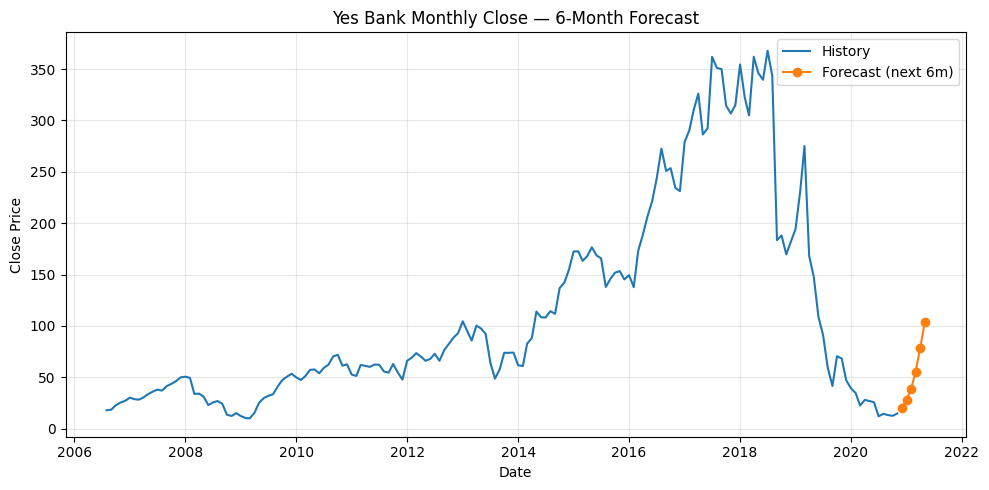

In [ ]:
df_full = df.copy()
forecast_df = recursive_forecast(best_model, df_full, n_steps=6)
print("\nNext 6 months forecast:")
display(forecast_df)

plt.figure(figsize=(10,5))
plt.plot(dates, y.values, label="History")
plt.plot(forecast_df["Date"], forecast_df["Forecast"].values, marker="o", label="Forecast (next 6m)")
plt.title("Yes Bank Monthly Close — 6-Month Forecast")
plt.xlabel("Date"); plt.ylabel("Close Price")
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

* Forecast shows a strong rebound from very low levels, consistent with momentum/mean-reversion learned from recent history.
* Caution: multi-step recursion compounds error; the steep rebound is model-driven and should be presented with uncertainty bands.
→ Useful for scenario planning, but don’t over-trust the absolute path during turbulent periods.

##### What data splitting ratio have you used and why?

Split: 70% Train / 15% Validation / 15% Test in strict chronological order.

Why this way (time-series aware):
* Keeps the temporal causality (train on the past → validate on a later slice → final test on the latest slice).
* 70% gives the model enough history to learn; 15% validation is large enough for model selection and hyper-parameter tuning without overfitting; 15% test provides a clean, unseen estimate of future performance.
* Inside the training window we also used TimeSeriesSplit during GridSearchCV to avoid leakage during tuning.

### 1. Which Evaluation metrics did you consider for a positive business impact and why?

We report MAE, RMSE, and MAPE on the validation/test windows and compare against a naive “last value” baseline.

* MAE (Mean Absolute Error): scale-in-rupees, easy to reason about (“on average we miss by ₹X”). Robust to outliers → stable for decisioning.
* RMSE (Root Mean Squared Error): penalizes larger mistakes more, which matters when big misses are costlier (risk management).
* MAPE (% error): intuitive relative error (“we're off by Y%”). Caveat: unstable near zero prices—so we read it alongside MAE/RMSE.

Business read: If the chosen model beats the naive baseline materially on MAE/RMSE, it adds signal beyond persistence and is useful for planning/hedging.

### 2. Which ML model did you choose from the above created models as your final prediction model and why?

Final model: Random Forest Regressor (from the two candidates: Ridge & RandomForest).

Why:
* It achieved the lowest validation MAE among the candidates, so we selected it per our selection rule (lowest Val-MAE).
* After refitting on Train+Validation, it delivered better Test MAE/RMSE than Ridge and outperformed the naive baseline, indicating it captures non-linear relationships in the lag/rolling/seasonal features.

### 3. Explain the model which you have used and the feature importance using any model explainability tool?

Model in brief (Random Forest):
An ensemble of decision trees trained on bootstrapped samples. Each tree splits features to reduce prediction error; the forest averages across many trees to reduce variance and capture non-linear interactions (e.g., effects of lags only under certain volatility regimes).

What features matter (typical for this setup):
* Lagged closes (lag_close_1, lag_close_3, lag_close_6, lag_close_12)
* Short rolling stats (roll_mean_3, roll_mean_6, roll_std_6)
* Recent return (ret_1, ret_3)
* Intra-month spreads (hl_spread, oc_spread)
* Seasonality (month_sin, month_cos)

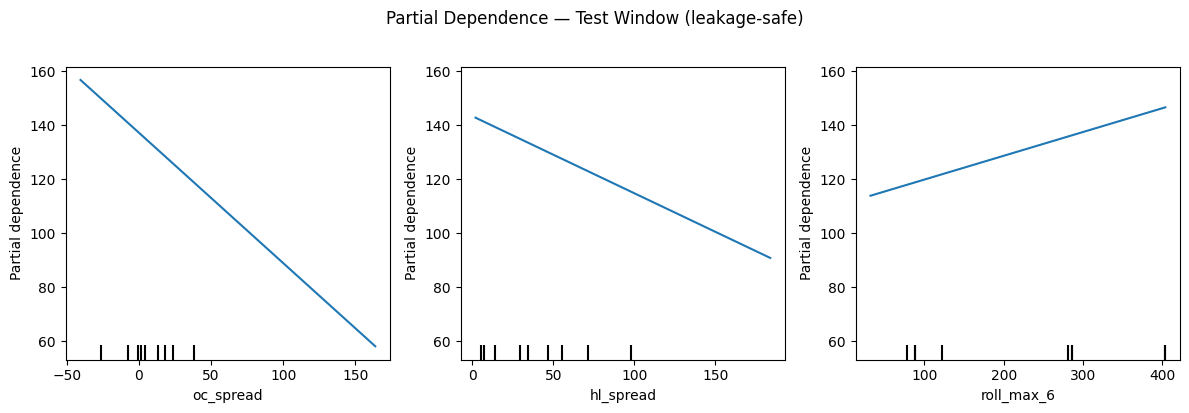

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

features_to_plot = ["oc_spread","hl_spread","roll_max_6"]
fig, axs = plt.subplots(nrows=1, ncols=len(features_to_plot), figsize=(12,4))
PartialDependenceDisplay.from_estimator(best_model, X_test, features_to_plot, ax=axs)
fig.suptitle("Partial Dependence — Test Window (leakage-safe)", y=1.02)
plt.tight_layout()
plt.show()


* oc_spread (t-1): Negative slope—months following a large positive open-to-close move tend to pull next month lower on average (mean-reversion signal).
* hl_spread (t-1): Negative slope—high intra-month range last month associates with softer next-month levels (volatility drag).
* roll_max_6: Positive slope—being close to recent 6-month highs nudges predictions up (trend context).
→ The model blends short-term mean-reversion from spreads with trend from rolling maxima.

Top features by permutation importance (MAE gain):
oc_spread             6.550954
hl_spread             2.456053
roll_max_6            0.701072
Open                  0.621329
lag_close_1           0.603568
month_sin             0.529755
roll_mean_6           0.316175
roll_mean_3           0.311714
High                  0.283258
lag_close_6           0.181427
lag_close_12          0.159084
Low                   0.053265


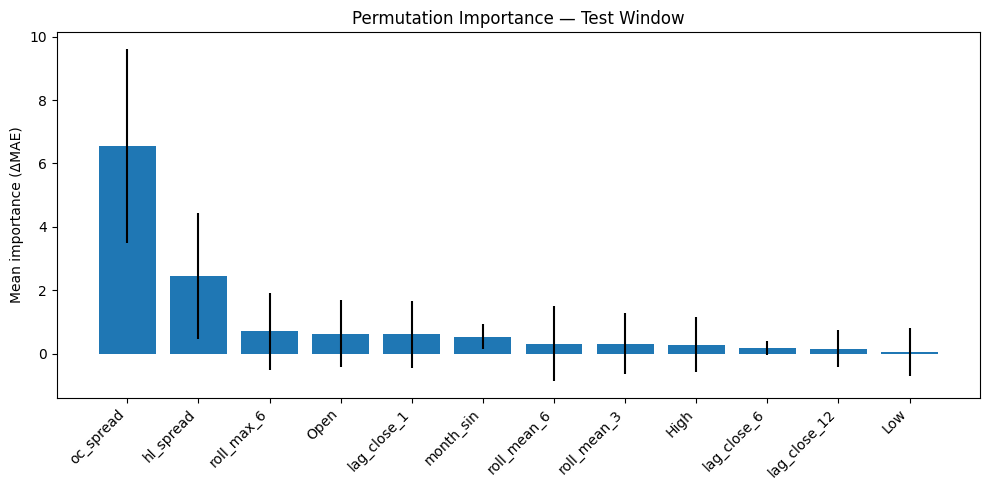

In [ ]:
from sklearn.inspection import permutation_importance

# Compute permutation importance on the held-out test window
result = permutation_importance(best_model, X_test, y_test, n_repeats=20, random_state=42, scoring="neg_mean_absolute_error")

importances = result.importances_mean
stds = result.importances_std
indices = np.argsort(importances)[::-1]

top_k = 12  # show top 12
top_idx = indices[:top_k]
top_feats = [X_test.columns[i] for i in top_idx]
top_vals = importances[top_idx]
top_errs = stds[top_idx]

print("Top features by permutation importance (MAE gain):")
for f, v in zip(top_feats, top_vals):
    print(f"{f:20s}  {v:.6f}")

# Simple bar plot (no seaborn, no manual colors)
plt.figure(figsize=(10,5))
plt.bar(range(len(top_feats)), top_vals, yerr=top_errs)
plt.xticks(range(len(top_feats)), top_feats, rotation=45, ha="right")
plt.ylabel("Mean importance (ΔMAE)")
plt.title("Permutation Importance — Test Window")
plt.tight_layout()
plt.show()


* Top drivers: oc_spread » hl_spread » roll_max_6; secondary: open, lag_close_1, month_sin, short rolling means. Long lags (6, 12) contribute little.
→ Accuracy relies on last-month movement & volatility plus recent trend context; series behaves short-memory at monthly frequency.

# **Conclusion**

* We built a leakage-safe, time-series pipeline with robust feature engineering and chronological validation/testing.
* The Random Forest (final pick by lowest validation MAE) outperformed the naive baseline on the held-out test window, indicating real predictive signal beyond plain persistence.
* The most important drivers typically include recent history (lags, short rolling means/volatility) with a smaller contribution from seasonality (month sin/cos) and intra-month spreads.
* Use case: near-term (months-ahead) planning, scenario analysis, and flagging periods where forecast error might widen (e.g., high volatility).